## SummariseEmbeddingsOverGroupings
This script:
- Reads in a pickle files which contains a dataframe with one row per sampled image. Each image is associated with a location (lat, lon), a link to the image_file, an embedding, category_scores, and the cluster the image has been assigned to with both 2 and 7 total clusters
- Finds the percentage of images in each LSOA, within each of the clusters
- Finds the mean/min/max embedding within each cluster, within each LSOA
- Saves a pickle file containing a dataframe containing this information

In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed

def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

from functions import *

In [3]:
data_dir = os.path.join("../../../../data/embeddings/")

In [31]:
k=7

### Get data

In [7]:
points_data_cache = data_dir + f"embeddings/one_row_per_image_cleaned_with_cluster_numbers.pkl"
with open(points_data_cache, "rb") as f:
    expanded_gdf = pickle.load(f)

In [41]:
for num in range(1,8):
    print(num)
    print(len(expanded_gdf[expanded_gdf['scene_cluster_7']==num]))

1
10758
2
12799
3
15354
4
13970
5
7517
6
7150
7
7928


In [ ]:
# final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
# file_ending = f'kmeanscluster{k}_resampled1'
# final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_{file_ending}.pkl")

# Test model performance 


### Read in IMD data

In [8]:
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Create a dictionary with random samples of the embedding points
Each key is a sample size between 500 and 20000  
Each item is a dataframe containing a random sample of rows from the dataframe  
If there are not enough images in that cluster, then no sample is made, and NA is recorded instead

In [25]:
cluster_col = "scene_cluster_7"

# Specify the size of subsamples we wish to make
sample_sizes = [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]

# Function to 
def sub_sample_data(df, cluster_col, n_per_cluster, random_state=None):
    """
    Take a sample from a dataframe by sampling up to
    n_per_cluster rows from each cluster.

    If a cluster has fewer than n_per_cluster rows, all rows
    from that cluster are used instead (i.e. the sample is capped).
    """

    # This inner function is applied separately to each cluster
    def sample_group(x):
        # x is the subset of df corresponding to one cluster
        # x.name is the cluster label (from groupby)

        # If the cluster is smaller than the requested sample size,
        # print a message so we know sampling was capped
        if len(x) < n_per_cluster:
            print(
                f"Cluster {x.name}: capped at {len(x)} "
                f"(requested {n_per_cluster})"
            )

        # Sample rows from this cluster:
        # - take n_per_cluster rows if possible
        # - otherwise take all available rows
        return x.sample(
            n=min(len(x), n_per_cluster),
            random_state=random_state
        )

    # Group the dataframe by cluster,
    # apply the sampling logic to each group,
    # then combine everything back into a single dataframe
    return (df.groupby(cluster_col, group_keys=False).apply(sample_group).reset_index(drop=True) )

# Variables to check whether cluster samples are capped or not.
cluster_sizes = expanded_gdf[cluster_col].value_counts()
max_n = cluster_sizes.min()

balanced_samples = {}
sampling_status = {}

for n in sample_sizes:
    
    # Create balanced sample
    balanced_samples[n] = sub_sample_data(expanded_gdf,cluster_col, n_per_cluster=n,random_state=42)
    
    # Record whether each cluster was capped or not
    sampling_status[n] = {
        cluster: (
            "full" if cluster_sizes[cluster] >= n else "capped")
        for cluster in cluster_sizes.index}

Cluster 5: capped at 7517 (requested 10000)
Cluster 6: capped at 7150 (requested 10000)
Cluster 7: capped at 7928 (requested 10000)
Cluster 1: capped at 10758 (requested 12500)
Cluster 5: capped at 7517 (requested 12500)
Cluster 6: capped at 7150 (requested 12500)
Cluster 7: capped at 7928 (requested 12500)
Cluster 1: capped at 10758 (requested 15000)
Cluster 2: capped at 12799 (requested 15000)
Cluster 4: capped at 13970 (requested 15000)
Cluster 5: capped at 7517 (requested 15000)
Cluster 6: capped at 7150 (requested 15000)
Cluster 7: capped at 7928 (requested 15000)
Cluster 1: capped at 10758 (requested 20000)
Cluster 2: capped at 12799 (requested 20000)
Cluster 3: capped at 15354 (requested 20000)
Cluster 4: capped at 13970 (requested 20000)
Cluster 5: capped at 7517 (requested 20000)
Cluster 6: capped at 7150 (requested 20000)
Cluster 7: capped at 7928 (requested 20000)


### Fit models using subsamples of the data for each cluster, and compare performance
- For each sample size between 500 and 20000:  
    - And each value of k between 2 and 10:
        - Run the model using just the embeddings for the images in each of the clusters

In [34]:
def fit_models_for_k_sample( k, sample_size, df, expanded_gdf, imd, mean_embed, is_missing_embedding,sampling_status):

    # Specifiy the correct column 
    category_column = f"scene_cluster_{k}"
    
    # Create dictionary to store results
    results = {}

    # Define a list of cluster numbers
    categories = np.array(range(1,k+1))

    # 1. Find the mean embedding in each LSOA across images found within each cluster
    # Create a list of dataframes
    # Each entry in the list is a dataframe containing the mean embedding for each cluster 
    per_cluster_dfs = [df[df[category_column] == cat].groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
        .rename(columns={"embedding": f"{cat}_mean"})
        for cat in categories]

    # Convert the list of dataframes into one dataframe, with each colum being the mean embedding in an LSOA for each cluster number
    merged = reduce( lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
        per_cluster_dfs)

    # 2. Create a dataframe containing for each LSOA, the overall mean embedding and the mean embedding within each cluster
    final_df = merged

    # 3. Joint to the IMD data
    final_df = pd.merge(final_df, imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
    final_df["imd_rerank"] = final_df["imd_rank"].rank(method="first").astype(int)

    # 4. Fit models per cluster 
    # --- For each cluster number 
    for cluster_num in range(1, k + 1):
        #print(cluster_num)

        # Don't fit a model if this cluster was capped at this sample size
        if sampling_status[sample_size].get(cluster_num) == "capped":
            results[cluster_num] = np.nan
            continue

        # Specify the column we're focusing on
        column = f"{cluster_num}_mean"
        # Get just the data for this column 
        one_image_type = final_df[["LSOA21CD", column, "imd_rerank"]].copy()
        # Add a column showing that there is no embedding for this LSOA for this cluster number
        one_image_type["missing"] = (one_image_type[column].apply(is_missing_embedding).astype(int))

        # Keep only LSOAs which have an embedding 
        one_image_type = one_image_type[one_image_type["missing"] == 0]

        # Don't run the model if there are less than 5 images
        if len(one_image_type) < 5:
            results[cluster_num] = np.nan
            continue

        # Run the model
        X = np.stack(one_image_type[column].values)
        y = one_image_type["imd_rerank"].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42 )

        rf = RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=1)

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        results[cluster_num] = r2_score(y_test, y_pred)

    return k, sample_size, results


# Runs the function _fit_models_for_k and saves files along the way
def fit_models_for_k_sample_save(k, sample_size, df, expanded_gdf, imd, mean_embed,
                                 is_missing_embedding, sampling_status,
                                 save_dir="results/"):

    # make sure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Run
    k_val, sample_size_val, cluster_results = fit_models_for_k_sample(
        k, sample_size, df, expanded_gdf, imd, mean_embed,
        is_missing_embedding, sampling_status)

    # Save immediately to disk
    file_path = os.path.join(save_dir, f"results_k{k}_n{sample_size}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(cluster_results, f)

    return k_val, sample_size_val, cluster_results


# Check if results already exist, and load them
# If they don't exist, then create them:

if os.path.exists(data_dir + 'model_testing/results_dict_plotting.pkl'):
    with open(data_dir + 'model_testing/results_dict_plotting.pkl', "rb") as f:
        results = pickle.load(f)
else:
    # Create a dictionary to store the results
    results = {}
    k_values= range(2,11)
    n_jobs = 8  # adjust to your machine

    # Run fit_models_for_k_sample_save using parallelisation
    outputs = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(fit_models_for_k_sample_save)(
            k, sample_size, balanced_samples[sample_size],
            expanded_gdf, imd, mean_embed,
            is_missing_embedding, sampling_status)
        for k in k_values
        for sample_size in sample_sizes)

    # Assemble results from outputs
    for k, sample_size, cluster_results in outputs:
        if k not in results:
            results[k] = {}
        for cluster_num, r2 in cluster_results.items():
            results[k].setdefault(cluster_num, {})[sample_size] = r2

    ### Save the results        
    with open(data_dir + 'model_testing/results_dict_plotting.pkl', "wb") as f:
        pickle.dump(results, f)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 15.0min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 21.1min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 27.7min


1
2
1
2
1
2
3
1
2
3
4
1
2
3
4
5
1
2
3
4
5
6
1
2
3
4
5
6
7
1
2
3
4
5
6
7


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 35.2min


1
2
1
2
1
2
3
1
2
3
4
1
2
3
4
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
6
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8


[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 44.1min


1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9


[Parallel(n_jobs=8)]: Done 104 out of 108 | elapsed: 62.1min remaining:  2.4min
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed: 63.9min finished


1
2
3
4
5
6
7
8
9
10


In [ ]:
# Forgotten what this does

# for k, sample_size, cluster_results in outputs:
#     if k not in results:
#         results[k] = {}
#     for cluster_num, r2 in cluster_results.items():
#         results[k].setdefault(cluster_num, {})[sample_size] = r2

### Plot the results

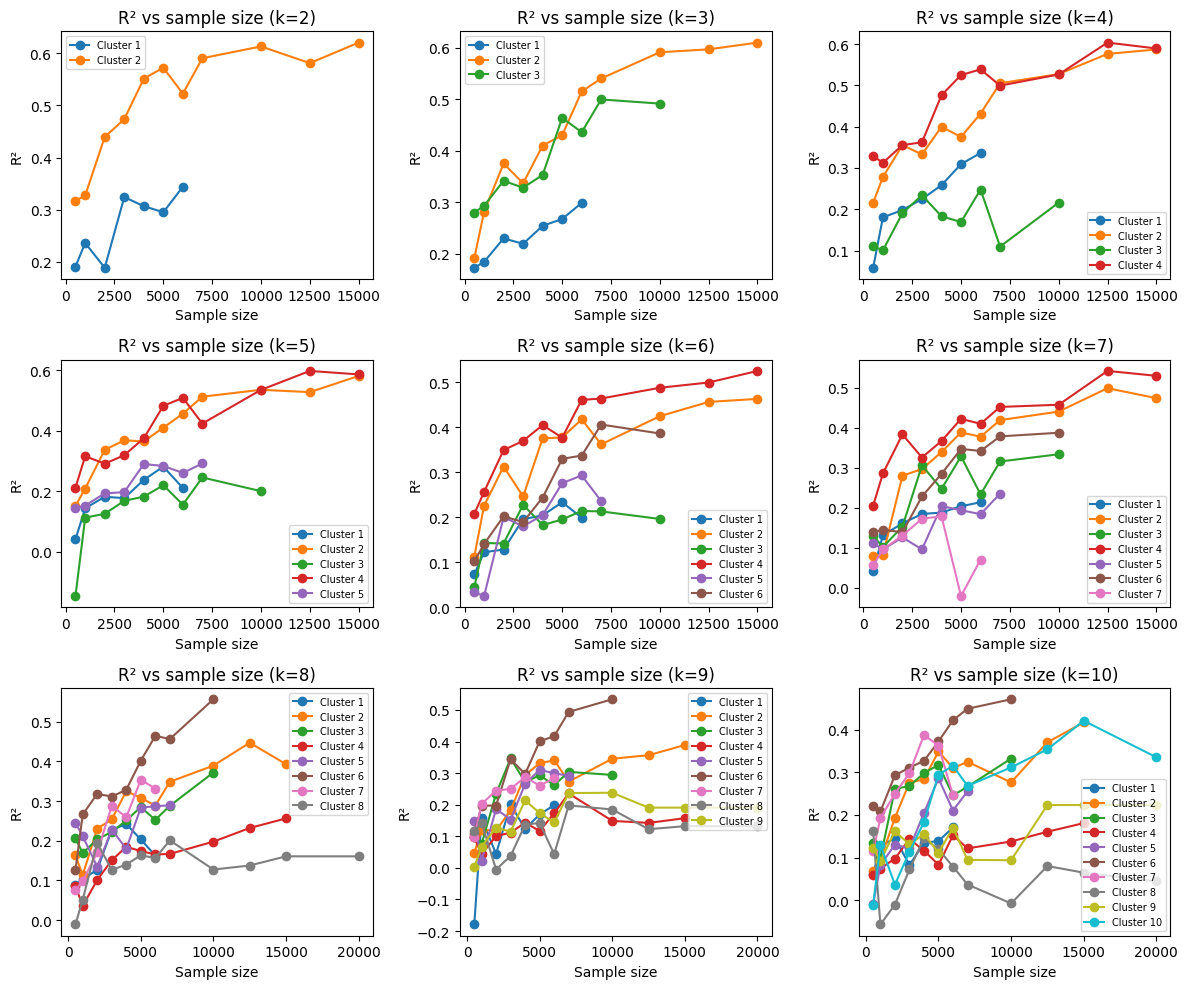

In [33]:
fig,axs=plt.subplots(ncols=3,nrows=3, figsize=(12,10))
axs=axs.flatten()
for ax_num, k in enumerate(range(2,11)):
    for cluster_num, sample_dict in results[k].items():
        x, y = zip(*sorted(sample_dict.items()))
        axs[ax_num].plot(x, y, marker='o', label=f"Cluster {cluster_num}")

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel("R²")
    axs[ax_num].set_title(f"R² vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
fig.tight_layout()

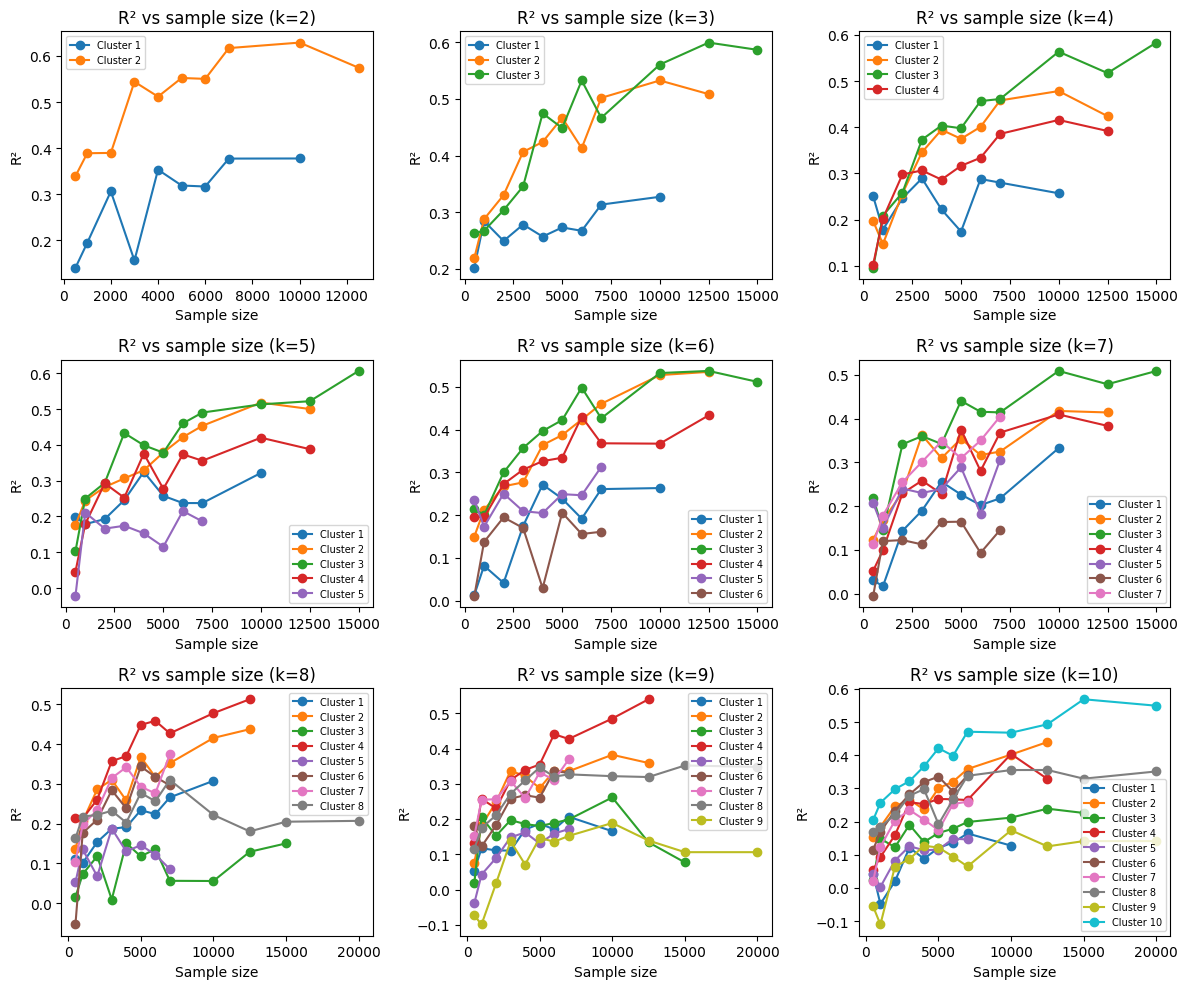

In [36]:
fig,axs=plt.subplots(ncols=3,nrows=3, figsize=(12,10))
axs=axs.flatten()
for ax_num, k in enumerate(range(2,11)):
    for cluster_num, sample_dict in results[k].items():
        x, y = zip(*sorted(sample_dict.items()))
        axs[ax_num].plot(x, y, marker='o', label=f"Cluster {cluster_num}")

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel("R²")
    axs[ax_num].set_title(f"R² vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
fig.tight_layout()